In [1]:
from datetime import datetime, timedelta
import geopandas as gpd
import json
import pandas as pd
import mapclassify
import matplotlib.pyplot as plt
import numpy as np
import os
import requests
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from io import StringIO
import warnings

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", None)
np.set_printoptions(threshold=np.inf)

/opt/homebrew/lib/python3.10/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# Parameters
parent_dir = os.path.abspath('..')  # get the absolute path of the parent directory

In [3]:
file_path = os.path.join(parent_dir, 'Data', 'rodents_per_year_merged.csv')  # construct the file path
rodents_df = pd.read_csv(file_path)
print(len(rodents_df))
rodents_df.head()

38958


,spatial_id,year,l_Commercial_sum,l_Other_sum,l_Outdoor_sum,l_Residential_sum,l_Residential-Mixed_sum,l_Vacant_Space_sum,d_Friday_sum,d_Monday_sum,d_Saturday_sum,d_Sunday_sum,d_Thursday_sum,d_Tuesday_sum,d_Wednesday_sum,t_Evening_sum,t_Midday_sum,t_Morning_sum,num_sightings,s_Dead_Animal:Residential_sum,s_Dead_Animal:Street_sum,s_Dog_waste:Street_sum,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_MissedService:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,num_dsny_complaints,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Bakery Products/Desserts_sum,c_Caribbean_sum,c_Chinese_sum,c_Coffee/Tea_sum,c_Italian_sum,c_Japanese_sum,c_Latin American_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum,num_violations
0,360050001000,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,360050001000,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,360050001000,2022,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,360050001000,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,360050001000,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
len(rodents_df)

38958

In [5]:
rodents_df.year.unique()

array([2020, 2021, 2022, 2018, 2019, 2023])

In [6]:
#take the years 2018 and 2019 (prepandemic) to test it out
rodents_df_2018_19 = rodents_df.loc[(rodents_df['year'] == 2018) | (rodents_df['year'] == 2019)]
rodents_df_2018_19.head()

,spatial_id,year,l_Commercial_sum,l_Other_sum,l_Outdoor_sum,l_Residential_sum,l_Residential-Mixed_sum,l_Vacant_Space_sum,d_Friday_sum,d_Monday_sum,d_Saturday_sum,d_Sunday_sum,d_Thursday_sum,d_Tuesday_sum,d_Wednesday_sum,t_Evening_sum,t_Midday_sum,t_Morning_sum,num_sightings,s_Dead_Animal:Residential_sum,s_Dead_Animal:Street_sum,s_Dog_waste:Street_sum,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_MissedService:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,num_dsny_complaints,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Bakery Products/Desserts_sum,c_Caribbean_sum,c_Chinese_sum,c_Coffee/Tea_sum,c_Italian_sum,c_Japanese_sum,c_Latin American_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum,num_violations
3,360050001000,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,360050001000,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,360050001001,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,360050001001,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,360050002000,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
rodents_df_2018_19.head(20)

,spatial_id,year,l_Commercial_sum,l_Other_sum,l_Outdoor_sum,l_Residential_sum,l_Residential-Mixed_sum,l_Vacant_Space_sum,d_Friday_sum,d_Monday_sum,d_Saturday_sum,d_Sunday_sum,d_Thursday_sum,d_Tuesday_sum,d_Wednesday_sum,t_Evening_sum,t_Midday_sum,t_Morning_sum,num_sightings,s_Dead_Animal:Residential_sum,s_Dead_Animal:Street_sum,s_Dog_waste:Street_sum,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_MissedService:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,num_dsny_complaints,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Bakery Products/Desserts_sum,c_Caribbean_sum,c_Chinese_sum,c_Coffee/Tea_sum,c_Italian_sum,c_Japanese_sum,c_Latin American_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum,num_violations
3,360050001000,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,360050001000,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,360050001001,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,360050001001,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,360050002000,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,360050002000,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,360050002001,2018,0.0,2.0,0.0,3.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,2.0,0.0,6.0,0.0,0.0,6.0,0.0,1.0,0.0,4.0,11.0,5.0,3.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,360050002001,2019,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,0.0,4.0,0.0,4.0,0.0,9.0,10.0,2.0,5.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,360050002002,2018,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,25.0,2.0,18.0,5.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,360050002002,2019,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,1.0,0.0,22.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
rodents_df_2018_19.columns

Index(['spatial_id', 'year', 'l_Commercial_sum', 'l_Other_sum',
       'l_Outdoor_sum', 'l_Residential_sum', 'l_Residential-Mixed_sum',
       'l_Vacant_Space_sum', 'd_Friday_sum', 'd_Monday_sum', 'd_Saturday_sum',
       'd_Sunday_sum', 'd_Thursday_sum', 'd_Tuesday_sum', 'd_Wednesday_sum',
       't_Evening_sum', 't_Midday_sum', 't_Morning_sum', 'num_sightings',
       's_Dead_Animal:Residential_sum', 's_Dead_Animal:Street_sum',
       's_Dog_waste:Street_sum', 's_Illegal_Dumping:Street_sum',
       's_Trash:Residential_sum', 's_Trash:Street_sum',
       's_Trash_MissedService:Street_sum', 's_Trash_Overflowing:Street_sum',
       's_Trash_Time:Street_sum', 's_Trash_Unsecure:Residential_sum',
       's_Trash_Unsecure:Street_sum', 'num_dsny_complaints', 'subway_count',
       'v_flies_sum', 'v_rats/mice_sum', 'v_roaches_sum', 'c_American_sum',
       'c_Bakery Products/Desserts_sum', 'c_Caribbean_sum', 'c_Chinese_sum',
       'c_Coffee/Tea_sum', 'c_Italian_sum', 'c_Japanese_sum',
      

In [8]:
#Using DT to do feature selection
#First try using num_sightings as the target variable
y_ns = rodents_df_2018_19['num_sightings']
x_feature_columns_v1 = []
for c in rodents_df_2018_19.columns:
    if(('v_' in c) or ('s_' in c) or ('c_' in c)):
        x_feature_columns_v1.append(c)
X_v1 = rodents_df_2018_19[x_feature_columns_v1]

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X_v1, y_ns, test_size=0.3,random_state=370)
dtr = DecisionTreeRegressor(max_depth=5)

In [10]:
dtr.fit(X_train, y_train)
Feature_importance=pd.DataFrame([list(X_train.columns),list(dtr.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top 10 most important features in order
Feature_importance.sort_values(by="importance",ascending=False).iloc[:10,:]

,variables,importance
5,s_Trash:Street_sum,0.400301
6,s_Trash_MissedService:Street_sum,0.29016
10,s_Trash_Unsecure:Street_sum,0.146666
3,s_Illegal_Dumping:Street_sum,0.106149
9,s_Trash_Unsecure:Residential_sum,0.028032
22,c_Mexican_sum,0.017844
4,s_Trash:Residential_sum,0.010849
0,s_Dead_Animal:Residential_sum,0.0
16,c_Caribbean_sum,0.0
23,c_Pizza_sum,0.0


In [11]:
nyc_rodents_df = rodents_df_2018_19
nyc_rodents_df.columns

Index(['spatial_id', 'year', 'l_Commercial_sum', 'l_Other_sum',
       'l_Outdoor_sum', 'l_Residential_sum', 'l_Residential-Mixed_sum',
       'l_Vacant_Space_sum', 'd_Friday_sum', 'd_Monday_sum', 'd_Saturday_sum',
       'd_Sunday_sum', 'd_Thursday_sum', 'd_Tuesday_sum', 'd_Wednesday_sum',
       't_Evening_sum', 't_Midday_sum', 't_Morning_sum', 'num_sightings',
       's_Dead_Animal:Residential_sum', 's_Dead_Animal:Street_sum',
       's_Dog_waste:Street_sum', 's_Illegal_Dumping:Street_sum',
       's_Trash:Residential_sum', 's_Trash:Street_sum',
       's_Trash_MissedService:Street_sum', 's_Trash_Overflowing:Street_sum',
       's_Trash_Time:Street_sum', 's_Trash_Unsecure:Residential_sum',
       's_Trash_Unsecure:Street_sum', 'num_dsny_complaints', 'subway_count',
       'v_flies_sum', 'v_rats/mice_sum', 'v_roaches_sum', 'c_American_sum',
       'c_Bakery Products/Desserts_sum', 'c_Caribbean_sum', 'c_Chinese_sum',
       'c_Coffee/Tea_sum', 'c_Italian_sum', 'c_Japanese_sum',
      

In [12]:
nyc_rodents_df.head(10)

,spatial_id,year,l_Commercial_sum,l_Other_sum,l_Outdoor_sum,l_Residential_sum,l_Residential-Mixed_sum,l_Vacant_Space_sum,d_Friday_sum,d_Monday_sum,d_Saturday_sum,d_Sunday_sum,d_Thursday_sum,d_Tuesday_sum,d_Wednesday_sum,t_Evening_sum,t_Midday_sum,t_Morning_sum,num_sightings,s_Dead_Animal:Residential_sum,s_Dead_Animal:Street_sum,s_Dog_waste:Street_sum,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_MissedService:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,num_dsny_complaints,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Bakery Products/Desserts_sum,c_Caribbean_sum,c_Chinese_sum,c_Coffee/Tea_sum,c_Italian_sum,c_Japanese_sum,c_Latin American_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum,num_violations
3,360050001000,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,360050001000,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,360050001001,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,360050001001,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,360050002000,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,360050002000,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,360050002001,2018,0.0,2.0,0.0,3.0,1.0,0.0,2.0,0.0,1.0,0.0,1.0,2.0,0.0,6.0,0.0,0.0,6.0,0.0,1.0,0.0,4.0,11.0,5.0,3.0,0.0,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,360050002001,2019,0.0,0.0,0.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,1.0,0.0,4.0,0.0,4.0,0.0,9.0,10.0,2.0,5.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,360050002002,2018,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,25.0,2.0,18.0,5.0,0.0,0.0,0.0,0.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,360050002002,2019,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,0.0,3.0,0.0,1.0,0.0,22.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
#getting total num of restaurants in each bgrp
restaurance_columns = []
nyc_rodents_df['total_restaurant'] = 0
for c in nyc_rodents_df.columns:
    if ('c_' in c):
        restaurance_columns.append(c)
for c in restaurance_columns:
    nyc_rodents_df['total_restaurant'] = nyc_rodents_df[c] + nyc_rodents_df['total_restaurant']

In [15]:
nyc_rodents_df.head()

,spatial_id,year,l_Commercial_sum,l_Other_sum,l_Outdoor_sum,l_Residential_sum,l_Residential-Mixed_sum,l_Vacant_Space_sum,d_Friday_sum,d_Monday_sum,d_Saturday_sum,d_Sunday_sum,d_Thursday_sum,d_Tuesday_sum,d_Wednesday_sum,t_Evening_sum,t_Midday_sum,t_Morning_sum,num_sightings,s_Dead_Animal:Residential_sum,s_Dead_Animal:Street_sum,s_Dog_waste:Street_sum,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_MissedService:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,num_dsny_complaints,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Bakery Products/Desserts_sum,c_Caribbean_sum,c_Chinese_sum,c_Coffee/Tea_sum,c_Italian_sum,c_Japanese_sum,c_Latin American_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum,num_violations,total_restaurant
3,360050001000,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,360050001000,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,360050001001,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,360050001001,2019,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,360050002000,2018,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
X_v2 = nyc_rodents_df[['subway_count','num_dsny_complaints','num_violations','total_restaurant','l_Commercial_sum','l_Other_sum','l_Outdoor_sum','l_Residential_sum','l_Residential-Mixed_sum','l_Residential-Mixed_sum']]
X_v2.head()

,subway_count,num_dsny_complaints,num_violations,total_restaurant,l_Commercial_sum,l_Other_sum,l_Outdoor_sum,l_Residential_sum,l_Residential-Mixed_sum,l_Residential-Mixed_sum
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
y_ns = nyc_rodents_df['num_sightings']

In [19]:
X_train,X_test,y_train,y_test=train_test_split(X_v2, y_ns, test_size=0.3,random_state=370)
dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(X_train, y_train)
Feature_importance=pd.DataFrame([list(X_train.columns),list(dtr.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top most important features in order
Feature_importance.sort_values(by="importance",ascending=False).iloc[:8,:]

,variables,importance
7,l_Residential_sum,0.922089
5,l_Other_sum,0.039151
4,l_Commercial_sum,0.02238
9,l_Residential-Mixed_sum,0.010731
1,num_dsny_complaints,0.004377
8,l_Residential-Mixed_sum,0.001272
0,subway_count,0.0
2,num_violations,0.0


In [20]:
rodents_df_2020_21 = rodents_df.loc[(rodents_df['year'] == 2020) | (rodents_df['year'] == 2021)]
rodents_df_2020_21.head()

,spatial_id,year,l_Commercial_sum,l_Other_sum,l_Outdoor_sum,l_Residential_sum,l_Residential-Mixed_sum,l_Vacant_Space_sum,d_Friday_sum,d_Monday_sum,d_Saturday_sum,d_Sunday_sum,d_Thursday_sum,d_Tuesday_sum,d_Wednesday_sum,t_Evening_sum,t_Midday_sum,t_Morning_sum,num_sightings,s_Dead_Animal:Residential_sum,s_Dead_Animal:Street_sum,s_Dog_waste:Street_sum,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_MissedService:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,num_dsny_complaints,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Bakery Products/Desserts_sum,c_Caribbean_sum,c_Chinese_sum,c_Coffee/Tea_sum,c_Italian_sum,c_Japanese_sum,c_Latin American_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum,num_violations
0,360050001000,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,360050001000,2021,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,360050001001,2020,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,360050001001,2021,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12,360050002000,2020,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
len(rodents_df_2020_21)

12986

In [22]:
nyc_rodents_seen_20_21_df = rodents_df_2020_21[rodents_df_2020_21.num_sightings != 0]
len(nyc_rodents_seen_20_21_df)

8160

In [25]:
rodents_df_2020_21['total_restaurant'] = 0
for c in restaurance_columns:
    rodents_df_2020_21['total_restaurant'] = rodents_df_2020_21[c] + rodents_df_2020_21['total_restaurant']
    

In [26]:
X_v3 = rodents_df_2020_21[['subway_count','num_dsny_complaints','num_violations','total_restaurant','l_Commercial_sum','l_Other_sum','l_Outdoor_sum','l_Residential_sum','l_Residential-Mixed_sum','l_Residential-Mixed_sum']]

In [27]:
X_v3.head()

,subway_count,num_dsny_complaints,num_violations,total_restaurant,l_Commercial_sum,l_Other_sum,l_Outdoor_sum,l_Residential_sum,l_Residential-Mixed_sum,l_Residential-Mixed_sum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
12,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
y_ns_v3 = rodents_df_2020_21['num_sightings']

In [29]:
X_train,X_test,y_train,y_test=train_test_split(X_v3, y_ns_v3, test_size=0.3,random_state=370)
dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(X_train, y_train)
Feature_importance=pd.DataFrame([list(X_train.columns),list(dtr.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top most important features in order
Feature_importance.sort_values(by="importance",ascending=False).iloc[:8,:]

,variables,importance
7,l_Residential_sum,0.871385
5,l_Other_sum,0.073673
4,l_Commercial_sum,0.041884
2,num_violations,0.006203
3,total_restaurant,0.004681
8,l_Residential-Mixed_sum,0.002173
0,subway_count,0.0
1,num_dsny_complaints,0.0


# Starting using all years' data, but ignoring the location type 

In [30]:
df = rodents_df.filter(regex='^(?!t_|d_|l_).*')
df_y = df[['num_sightings']]
df = df.drop(['year','spatial_id','num_sightings','num_violations','num_dsny_complaints'], axis=1)
df.head()

,s_Dead_Animal:Residential_sum,s_Dead_Animal:Street_sum,s_Dog_waste:Street_sum,s_Illegal_Dumping:Street_sum,s_Trash:Residential_sum,s_Trash:Street_sum,s_Trash_MissedService:Street_sum,s_Trash_Overflowing:Street_sum,s_Trash_Time:Street_sum,s_Trash_Unsecure:Residential_sum,s_Trash_Unsecure:Street_sum,subway_count,v_flies_sum,v_rats/mice_sum,v_roaches_sum,c_American_sum,c_Bakery Products/Desserts_sum,c_Caribbean_sum,c_Chinese_sum,c_Coffee/Tea_sum,c_Italian_sum,c_Japanese_sum,c_Latin American_sum,c_Mexican_sum,c_Pizza_sum,c_other_sum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


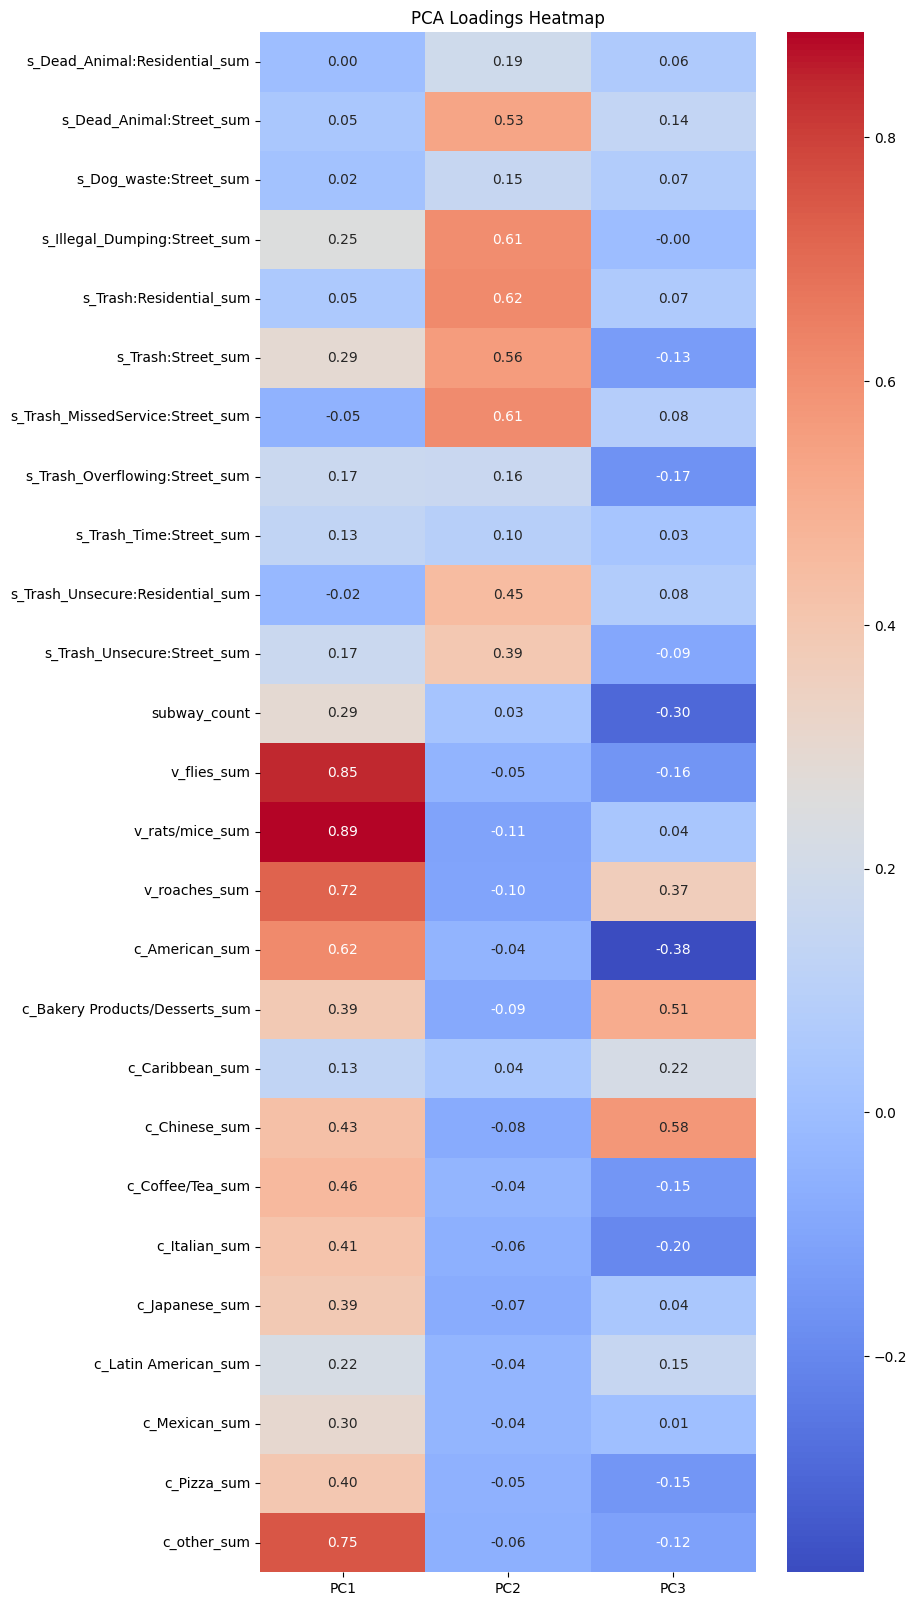

In [31]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

pca = PCA(n_components=3)
pca.fit(df_scaled)

# get the loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
df_loadings = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3'], index=df.columns)

import seaborn as sns
import matplotlib.pyplot as plt

# Generate heatmap using seaborn
plt.figure(figsize=(8,20))
sns.heatmap(df_loadings, cmap='coolwarm', annot=True, fmt='.2f')
plt.title('PCA Loadings Heatmap')
plt.show()

# Feature selection - using different metrics for rodent sightings

In [53]:
y_ns = rodents_df['num_sightings']
x_feature_columns = []
for c in rodents_df.columns:
    if(('v_' in c) or ('s_' in c) or ('c_' in c)):
        x_feature_columns.append(c)
x = rodents_df[x_feature_columns]

X_train,X_test,y_train,y_test=train_test_split(x, y_ns, test_size=0.3,random_state=370)
dtr = DecisionTreeRegressor(max_depth=4)
dtr.fit(X_train, y_train)
Feature_importance=pd.DataFrame([list(X_train.columns),list(dtr.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top most important features in order
Feature_importance.sort_values(by="importance",ascending=False).iloc[:5,:]

,variables,importance
5,s_Trash:Street_sum,0.831072
3,s_Illegal_Dumping:Street_sum,0.073634
10,s_Trash_Unsecure:Street_sum,0.073158
24,c_other_sum,0.009047
18,c_Coffee/Tea_sum,0.007825


In [57]:
#using dtr and rf for regression
from sklearn.metrics import r2_score

overall_score =r2_score(y_train, dtr.predict(X_train))
print("DT Train R-squared:", overall_score) 
overall_score = r2_score(y_test, dtr.predict(X_test))
print("DT Test R-squared:", overall_score) 

from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=20,random_state=370)
rfr.fit(X_train,y_train)
rf_score = rfr.score(X_train, y_train)
print("RF Train R-squared:", rf_score) 

rf_score = rfr.score(X_test, y_test)
print("RF Test R-squared:", rf_score) 

DT Train R-squared: 0.12621278930365076
DT Test R-squared: 0.10427672505876995
RF Train R-squared: 0.7511197332819205
RF Test R-squared: 0.010068763935223823


In [58]:
y_dsny = rodents_df.num_dsny_complaints
x_feature_on_DSNY = []
for c in rodents_df.columns:
    if((c[:2] == 'v_') or (c[:2] == 'c_') or (c[:2] == 'l_')):
        x_feature_on_DSNY.append(c)
x = rodents_df[x_feature_on_DSNY]

X_train,X_test,y_train,y_test=train_test_split(x, y_dsny, test_size=0.3,random_state=370)
dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(X_train, y_train)
Feature_importance=pd.DataFrame([list(X_train.columns),list(dtr.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top most important features in order
Feature_importance.sort_values(by="importance",ascending=False).iloc[:5,:]

,variables,importance
5,l_Vacant_Space_sum,0.310444
0,l_Commercial_sum,0.306277
3,l_Residential_sum,0.220096
6,v_flies_sum,0.070093
4,l_Residential-Mixed_sum,0.041862


In [59]:
#using dtr and rf for regression
from sklearn.metrics import r2_score

overall_score =r2_score(y_train, dtr.predict(X_train))
print("DT Train R-squared:", overall_score) 
overall_score = r2_score(y_test, dtr.predict(X_test))
print("DT Test R-squared:", overall_score) 

from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=20,random_state=370)
rfr.fit(X_train,y_train)
rf_score = rfr.score(X_train, y_train)
print("RF Train R-squared:", rf_score) 

rf_score = rfr.score(X_test, y_test)
print("RF Test R-squared:", rf_score) 

DT Train R-squared: 0.12928401885941143
DT Test R-squared: 0.06198127967963796
RF Train R-squared: 0.3318638022854937
RF Test R-squared: 0.02819345569258014


In [60]:
y_ri = rodents_df.num_violations 
x_features_on_ReInspect = []
for c in rodents_df.columns:
    if((c[:2] == 'l_') or (c[:2] == 's_')):
        x_features_on_ReInspect.append(c)
x = rodents_df[x_features_on_ReInspect]

X_train,X_test,y_train,y_test=train_test_split(x, y_ri, test_size=0.3,random_state=370)
dtr = DecisionTreeRegressor(max_depth=5)
dtr.fit(X_train, y_train)
Feature_importance=pd.DataFrame([list(X_train.columns),list(dtr.feature_importances_)]).T
Feature_importance.columns=["variables","importance"]

# list the top most important features in order
Feature_importance.sort_values(by="importance",ascending=False).iloc[:5,:]

,variables,importance
11,s_Trash:Street_sum,0.282677
0,l_Commercial_sum,0.163113
12,s_Trash_MissedService:Street_sum,0.130673
10,s_Trash:Residential_sum,0.127007
9,s_Illegal_Dumping:Street_sum,0.111477


In [61]:
#using dtr and rf for regression
from sklearn.metrics import r2_score

overall_score =r2_score(y_train, dtr.predict(X_train))
print("DT Train R-squared:", overall_score) 
overall_score = r2_score(y_test, dtr.predict(X_test))
print("DT Test R-squared:", overall_score) 

from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=20,random_state=370)
rfr.fit(X_train,y_train)
rf_score = rfr.score(X_train, y_train)
print("RF Train R-squared:", rf_score) 

rf_score = rfr.score(X_test, y_test)
print("RF Test R-squared:", rf_score) 

DT Train R-squared: 0.1718168800400912
DT Test R-squared: 0.0040747616633656225
RF Train R-squared: 0.7761706338817528
RF Test R-squared: 0.0689809980347561
